In [3]:
# increase the cell width 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; } </style>"))   

### Convert hotpotqa to squard format

According to Longformer: use the following input format with special tokens:  “[CLS] [q] question [/q] [p] sent1,1 [s] sent1,2 [s] ... [p] sent2,1 [s] sent2,2 [s] ...” 
where [s] and [p] are special tokens representing sentences and paragraphs. The special tokens were added to the RoBERTa vocabulary and randomly initialized before task finetuning.

In [4]:
import tqdm 
from datetime import datetime 
import pytz 
timeZ_Az = pytz.timezone('US/Mountain') 

QUESTION_START = '[question]'
QUESTION_END = '[/question]' 
TITLE_START = '<t> , '  # indicating the start of the title of a paragraph (also used for loss over paragraphs)
TITLE_END = ', </t> . '   # indicating the end of the title of a paragraph, add , to avoid tilte to be recognized as part of the first entity in the sentence after
SENT_MARKER_END = ', </sent> , '  # indicating the end of the title of a sentence (used for loss over sentences)
PAR = '[/par]'  # used for indicating end of the regular context and beginning of `yes/no/null` answers
EXTRA_ANSWERS = " yes no null </s>"

In [5]:
import sys
sys.path.insert(-1, '/xdisk/msurdeanu/fanluo/miniconda3/lib/python3.7/site-packages')
sys.path.insert(-1, '/xdisk/msurdeanu/fanluo/miniconda3/lib/python3.8/site-packages')
 
from prettytable import PrettyTable
import spacy   
print(spacy.__version__)
import en_core_web_lg          
nlp1 = en_core_web_lg.load() 
nlp2 = en_core_web_lg.load() 

from spacy.symbols import ORTH, LEMMA, POS
nlp1.tokenizer.add_special_case('</sent>', [{ ORTH: '</sent>', LEMMA: '</sent>', POS: 'SYM'}]) 
nlp1.tokenizer.add_special_case('</t>', [{ORTH: '</t>', LEMMA: '</t>', POS: 'SYM'}]) 
nlp1.tokenizer.add_special_case('<t>', [{ORTH: '<t>', LEMMA: '<t>', POS: 'SYM'}])  
import neuralcoref 
neuralcoref.add_to_pipe(nlp1, greedyness=0.55) # between 0 and 1. The default value is 0.5.


#!python -m pip install pytextrank
# Fan: make 3 changes in pytextrank.py 
# 1. phrase_text = ' '.join(key[0] for key in phrase_key) 
#  p.text are the joint of lemma tokens with pos_ in kept_pos, and maintain the order when join    
# 2. add argumrnt 'chunk_type' to only consider named entity ('ner') or noun_chunks ('noun'), besides the default ('both') 
# 3. replace token.lemma_ with token.lemma_.lower().strip()
import pytextrank
tr = pytextrank.TextRank(pos_kept=["ADJ", "NOUN", "PROPN", "VERB", "NUM", "ADV"], chunk_type='both')  
nlp2.add_pipe(tr.PipelineComponent, name='textrank', last=True)



%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cbook import flatten

#!conda install networkx --yes
import networkx as nx
import itertools 

2.3.5


### Create phrases graph  

In [6]:
def create_para_graph(paras_phrases):
    G = nx.Graph()    
    top_para_phrases = []                     # node of the first (top ranked) phrases from each para 
    for pi, para_phrases in enumerate(paras_phrases):        # each para 
        for si, sent_phrases in enumerate(para_phrases):     # each sent
            
            # complete graph for each sent
            G.add_nodes_from([(phrase[0], {"score": phrase[1]}) for phrase in sent_phrases])  
            for node1, node2 in itertools.combinations([phrase[0] for phrase in sent_phrases], 2):
                if(G.has_edge(node1, node2)):
                    G[node1][node2]['source'].append((pi, si))
                else:
                    G.add_edge(node1, node2, source = [(pi, si)])
                                               
                                                
            # add edge between title phrases and first phrase of the sentence
            # si = 0, sent_phrases = para_phrases[0] are phrases from title 
            for phrase in para_phrases[0]:
                if(sent_phrases[0] != phrase):
                    if(G.has_edge(sent_phrases[0], phrase)):
                        G[sent_phrases[0]][phrase]['source'].append((pi, 'title', si))
                    else:
                        G.add_edge(sent_phrases[0], phrase, source = (pi, 'title', si)) 
 
  #  Draw
    pos = nx.spring_layout(G)
    plt.figure(figsize=(20,10))
    nx.draw(G, pos, with_labels=True, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='orange', alpha=0.9                           
            )     
    
    
    
    return G


In [7]:
def vis_graph(H, nodes):
    
    G = H.subgraph(nodes)  # Returns a subgraph containing nodes in nbunch
    pos = nx.spring_layout(G)
    plt.figure(figsize=(20,10))
    nx.draw(G, pos, with_labels=True, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='orange', alpha=0.9                           
            )     
    
    for n, nbrs in G.adj.items():  # each node and its neighbors   
        for nbr, eattr in nbrs.items(): # each neighbor and edge attr
            print(f"({n}, {nbr}, {eattr})")
            
    return

### Compute the reduced context with phrase graph

In [23]:
### Compute the reduced context with phrase graph

import re
import string

from networkx.algorithms import approximation as approx
def reduce_context_with_phares_graph(example, q_id, gold_paras_only=False):
    """function to compute reduced context with phrase graph.

    Args:
        json_dict: The original data load from hotpotqa file.
        gold_paras_only: when is true, only use the 2 paragraphs that contain the gold supporting facts; if false, use all the 10 paragraphs
 
    Returns:
        a new file save additional phrase-related info and the reduced context

    """
    noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']
    new_dict = {"data": []} 
    common_phrases_num_le2 = 0
    extended = 0
    answer_in_reduced_context = 0
    answer_in_context = 0
    reduced_context_ratios = []

    raw_contexts = example["context"]
#         if gold_paras_only: 
#        raw_contexts = [lst for lst in raw_contexts if lst[0] in support_para]    
    paras_phrases = []                                                # phrases of all 10 paragraghs
    for i, para_context in enumerate(raw_contexts):                   # each para

        title = _normalize_text(para_context[0])          
        sents = [_normalize_text(sent) for sent in para_context[1]]
        num_sents_before_coref_resolved = len(sents)
        print("numbe of sents before coref: ", num_sents_before_coref_resolved)
        sents_joint =  (' ' + SENT_MARKER_END +' ').join(sents)
        print("sents: ", sents_joint) 
        sents_doc = nlp1(sents_joint)
        print("resolved_sents: ", sents_doc._.coref_resolved) 
        sents_coref_resolved = sents_doc._.coref_resolved.split(SENT_MARKER_END)
        num_sents_after_coref_resolved = len(sents_coref_resolved)
        print("numbe of sents after coref: ", num_sents_after_coref_resolved)
        
        if(num_sents_before_coref_resolved == num_sents_after_coref_resolved):
            sent_docs = list(nlp2.pipe([title] + sents_coref_resolved))       
        else:
            sent_docs = list(nlp2.pipe([title] + sents))
 
        para_phrases = []                                        
        for sent_doc in sent_docs:                                      # each sent in a para
            sent_phrases = [(p.text, p.rank) for p in sent_doc._.phrases if(p.text != '')]  # phrases from each sentence  
            para_phrases.append(sent_phrases)                           # para_phrases[0] are phrases from  title
        paras_phrases.append(para_phrases)    

#     contexts = [TITLE_START + ' ' + lst[0]  + ' ' + TITLE_END + ' ' + (' ' + SENT_MARKER_END +' ').join(lst[1]) + ' ' + SENT_MARKER_END for lst in raw_contexts]  
#     context = " ".join(contexts)                                                     

    answer = _normalize_text(example["answer"])  
    print('answer: ', answer)
#     if (answer != '' and len(list(re.finditer(answer, context, re.IGNORECASE))) > 0):
#         answer_in_context += 1

    paras_phrases_graph = create_para_graph(paras_phrases)
    all_sent_phrases_text =  list(flatten(paras_phrases))[::2]        # every other element is text, others are rank 
    Subgraphs = [paras_phrases_graph.subgraph(c).copy() for c in nx.connected_components(paras_phrases_graph)]

    question = _normalize_text(example["question"])
    question_doc = nlp2(question)
    question_phrases = [(p.text, p.rank) for p in question_doc._.phrases if(p.text != '')] 
    question_phrases_text = [p[0] for p in question_phrases]
    print("question_phrases_text: ", question_phrases_text)
    
    # question_phrases_text = set(list(flatten([p.split() for p in question_phrases_text])) + question_phrases_text) # add phrase words
#     print("question_phrases_text: ", question_phrases_text)

    RG = nx.Graph()    # relevant components  
    represnetive_nodes = []  # more likely to include the represnetive_nodes in the final path       
    for S in Subgraphs:
        for phrase in question_phrases_text:
            if S.has_node(phrase):
                RG = nx.compose(RG, S)  # joint the relevant components
                represnetive_node = sorted(S.nodes.data('score'), key=lambda x: x[1], reverse=True)[0]  # node with highest score
                represnetive_nodes.append(represnetive_node) 
                break
    
    for node1, node2 in itertools.combinations([phrase[0] for phrase in represnetive_nodes], 2):  
        RG.add_edge(node1, node2, source = 'components')

     
    
    #  Draw
    pos = nx.spring_layout(RG)
    plt.figure(figsize=(20,10))
    nx.draw(RG, pos, with_labels=True, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='orange', alpha=0.9                           
            )     
    
    common_phrases = []
    
    mapping = {}
    for phrase in RG.nodes:
        for q_phrase in question_phrases_text:
            if(phrase in q_phrase or q_phrase in phrase):
                mapping[phrase] = q_phrase   
                common_phrases.append(q_phrase)
    
    RG = nx.relabel_nodes(RG, mapping)      # match 'english government position' with 'government position'
    
#     list(set(RG.nodes).intersection(question_phrases_text)) 
    question_only_phrase = list(set(question_phrases_text).difference(common_phrases)) 

    example["question_phrases_text"] = question_phrases_text
    example["question_only_phrase"] = question_only_phrase

    if(len(common_phrases) > 1):
        common_phrases_num_le2 += 1
        path_phrases = list(approx.steinertree.steiner_tree(RG, common_phrases).nodes)  # to find the shortest path cover all common_phrases  
        extended_phrases = path_phrases + question_only_phrase  
        if(len(extended_phrases) > len(question_phrases_text)):
            extended += 1
    else: #  0 or 1 common phrases
        path_phrases = common_phrases             
        extended_phrases = question_phrases_text

    print("question: ", question)
    print("question_phrases: ", question_phrases)
    print("common_phrases: ", common_phrases)
    print("extended_phrases: ", extended_phrases)


    example["question_phrases"] = question_phrases
    example["paras_phrases"] = paras_phrases
#     example["all_sent_phrases_text"] = all_sent_phrases_text
    example["common_phrases"] = common_phrases
    example["path_phrases"] = path_phrases
    example["extended_phrases"] = extended_phrases 

    
    vis_graph(RG, extended_phrases) 
    
#        
#         print("\n\n") 
#         print("question_phrases: ", question_phrases)    
    print("paras_phrases")
    for paras_phrase in paras_phrases:
    #     print(paras_phrase )
        print(list(flatten(paras_phrase))[::2])
        print("\n") 
        
    print("phrases in relevant components")    
    print(RG.nodes.data())
        
    raw_reduced_contexts = []     # sentences contain one of the extended_phrases
    number_sentences = 0
    number_reduced_sentences = 0 
    kept_para_sent = []
    for para_id, (para_title, para_lines) in enumerate(raw_contexts):
# #             print("para_id, para_title, para_lines",para_id, para_title, para_lines)

        number_sentences += len(para_lines)
        reduced_para = []
        kept_sent = []
        for sent_id, sent in enumerate(para_lines):

            for phrase in extended_phrases:
                # every other element is text, others are rank 
                if(phrase in list(flatten(paras_phrases[para_id][sent_id+1]))[::2]):  # paras_phrases[para_id][0] are phrases from the title
                    reduced_para.append(sent)
                    number_reduced_sentences += 1 
                    kept_sent.append(sent_id)
                    break     # if current sentence contains one of the extended_phrases, this sentence is added to reduced sentence, and no need to continue checking whether it contains other phrases
        if(len(reduced_para) > 0):
            raw_reduced_contexts.append([para_title, reduced_para])
            kept_para_sent.append(kept_sent)
        else:
            for phrase in extended_phrases:
                if(phrase in list(flatten(paras_phrases[para_id][0]))[::2]):   # only tilte contains one of the extended_phrases
                    raw_reduced_contexts.append([para_title, []])
                    kept_para_sent.append(kept_sent)
                    break
                     
      
    assert number_reduced_sentences <= number_sentences                    
    reduced_context_ratios.append(number_reduced_sentences / number_sentences)    
 
    
    reduced_contexts = [TITLE_START + ' ' + lst[0]  + ' ' + TITLE_END + ' ' + (' ' + SENT_MARKER_END +' ').join(lst[1]) + ' ' + SENT_MARKER_END for lst in raw_reduced_contexts]    
    reduced_context_str = " ".join(reduced_contexts)  

    if (answer != '' and len(list(re.finditer(answer, reduced_context_str, re.IGNORECASE))) > 0):
        print("answer in reduced_context")
    else:
        print("answer not in reduced_context")

    supporting_facts = []
    support_para = set(
        para_title for para_title, _ in example["supporting_facts"]
    )
    sp_set = set(list(map(tuple, example['supporting_facts'])))                       # a list of (title, sent_id in orignal context) 
    print('supportiing facts: ', sp_set)
    for i, para_reduced_context in enumerate(raw_reduced_contexts):                   # each para
        if(para_reduced_context[0] in support_para):
            for sent_id, orig_sent_id in enumerate(kept_para_sent[i]):
                if( (para_reduced_context[0], orig_sent_id) in sp_set ):
                    supporting_facts.append([para_reduced_context[0], sent_id])

    example['reduced_context'] = raw_reduced_contexts
    example['supporting_facts'] = supporting_facts
    example['kept_para_sent'] = kept_para_sent
    print('reduced supportiing facts: ', supporting_facts)
    
    return example

In [24]:
def _normalize_text(s):

    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [25]:
import os
os.chdir('/xdisk/msurdeanu/fanluo/hotpotQA/')
#!cat /xdisk/msurdeanu/fanluo/hotpotQA/hotpot_train_v1.1.json | ../jq-linux64 -c '.[2:16]' > small.json
#!cat /xdisk/msurdeanu/fanluo/hotpotQA/hotpot_train_v1.1.json | ../jq-linux64 -c '.[380:400]' > small_dev.json
#!cat /xdisk/msurdeanu/fanluo/hotpotQA/hotpot_train_v1.1.json | ../jq-linux64 -c '.[31:50]' > sample.json

In [26]:
# debug: check args
import shlex
argString ='--datafile /xdisk/msurdeanu/fanluo/hotpotQA/Data/hotpot_dev_distractor_v1.json --qid 5a8c7595554299585d9e36b6'  # --outfile /xdisk/msurdeanu/fanluo/hotpotQA/small_out.json'
shlex.split(argString)

import json
import argparse 
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--datafile", type=str, default='small.json')
    parser.add_argument("--qid", type=str, default='5ae73acb5542991e8301cc07')
#    parser.add_argument("--outfile", type=str, default='small_out.json')
    args = parser.parse_args(shlex.split(argString)) 
     
    print(args.datafile)
    print(args.qid)
    question_json = !cat $args.datafile | /xdisk/msurdeanu/fanluo/helper/jq-linux64 -c --arg key $args.qid '.[] | select(._id | contains($key))'  # --arg key $args.qid is used to pass args.qid as a variable to jq
    
#     print(question_json)
    question = json.loads(question_json[0])    # Convert from JSON string to dict
    reduce_context_with_phares_graph(question, args.qid)

/xdisk/msurdeanu/fanluo/hotpotQA/Data/hotpot_dev_distractor_v1.json
5a8c7595554299585d9e36b6
numbe of sents before coref:  4
sents:  meet corliss archer program from radios golden age ran from january 7 1943 to september 30 1956 , </sent> ,  although it was cbss answer to nbcs popular date with judy it was also broadcast by nbc in 1948 as summer replacement for bob hope show , </sent> ,  from october 3 1952 to june 26 1953 it aired on abc finally returning to cbs , </sent> ,  despite programs long run fewer than 24 episodes are known to exist
resolved_sents:  meet corliss archer program from radios golden age ran from january 7 1943 to september 30 1956 , </sent> ,  although corliss archer program was cbss answer to nbcs popular date with judy corliss archer program was also broadcast by nbc in 1948 as summer replacement for meet corliss archer program from radios golden age hope show , </sent> ,  from october 3 1952 to june 26 1953 corliss archer program aired on abc finally returning

resolved_sents:  charles craft may 9 1902 – september 19 1968 was englishborn american film and television editor , </sent> ,  born in county of hampshire in england on may 9 1902 craft would enter film industry in hollywood in 1927 , </sent> ,  first film charles craft may 9 1902 – edited was universal pictures silent film painting town , </sent> ,  over next 25 years craft would edit 90 featurelength films , </sent> ,  in early 1950s charles craft may 9 1902 – would switch charles craft may 9 1902 – focus to small screen 90 featurelength films being racket squad from 1951–53 for which charles craft may 9 1902 – was main editor editing 93 of 98 episodes , </sent> ,  charles craft may 9 1902 – would work on several other series during 1950s including meet corliss archer 1954 science fiction theatre 1955–56 and highway patrol 1955–57 , </sent> ,  in late 1950s and early 1960s charles craft may 9 1902 – was one of main editors on sea hunt starring lloyd bridges editing over half of episo

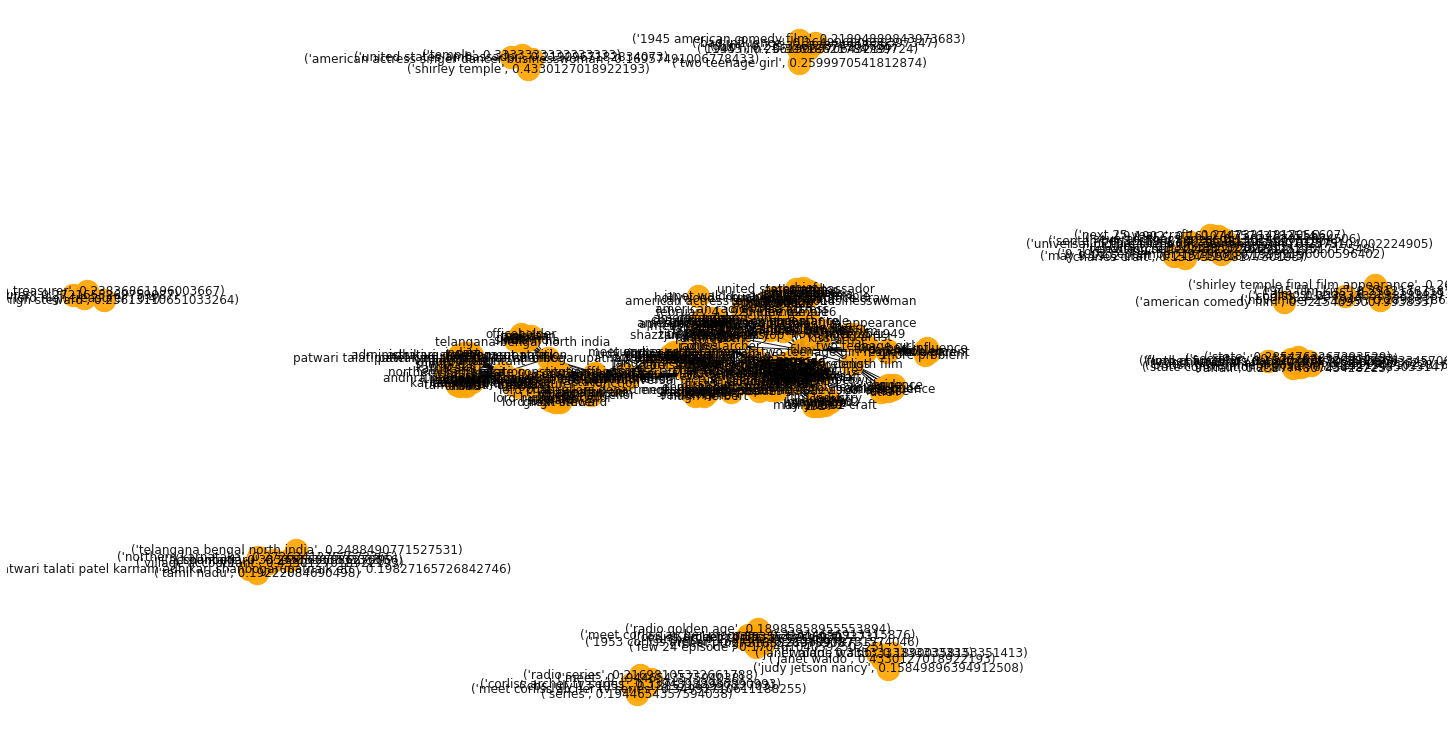

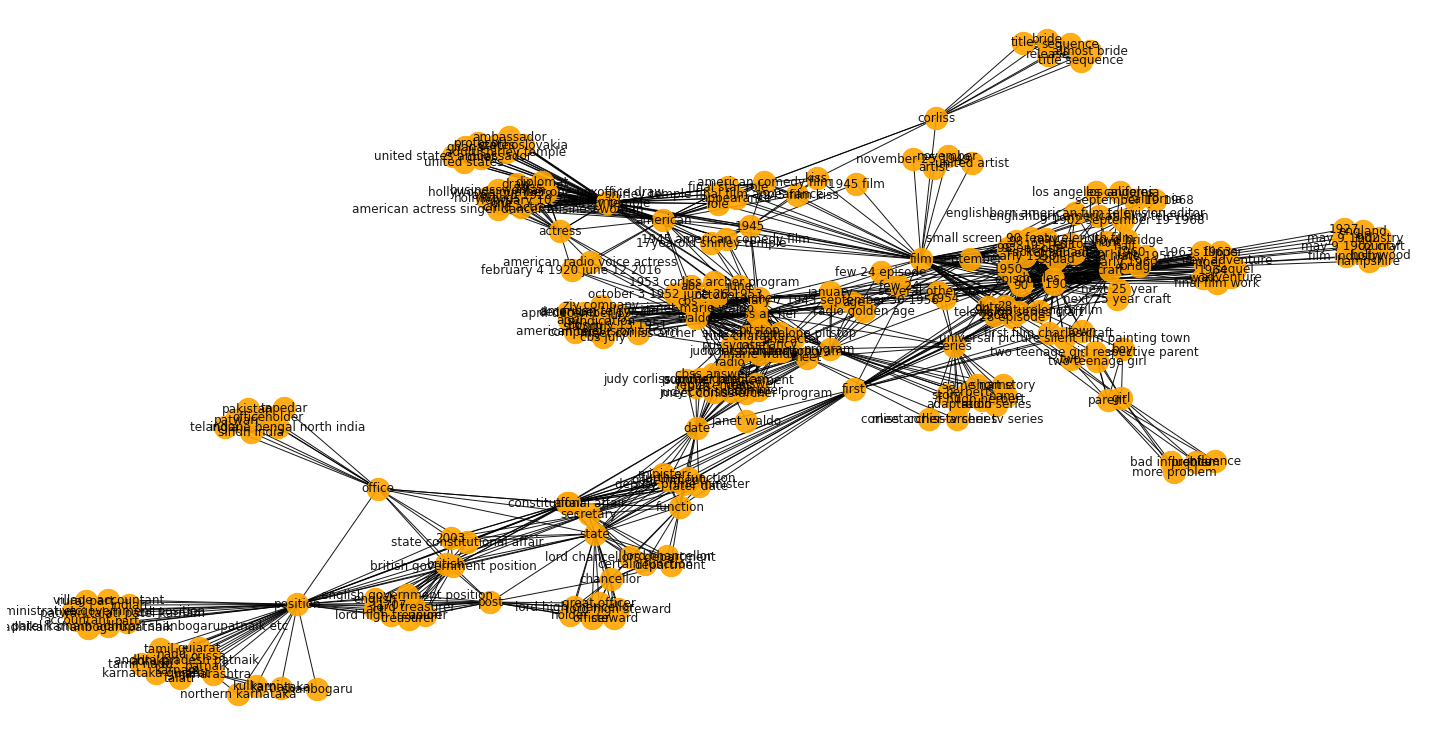

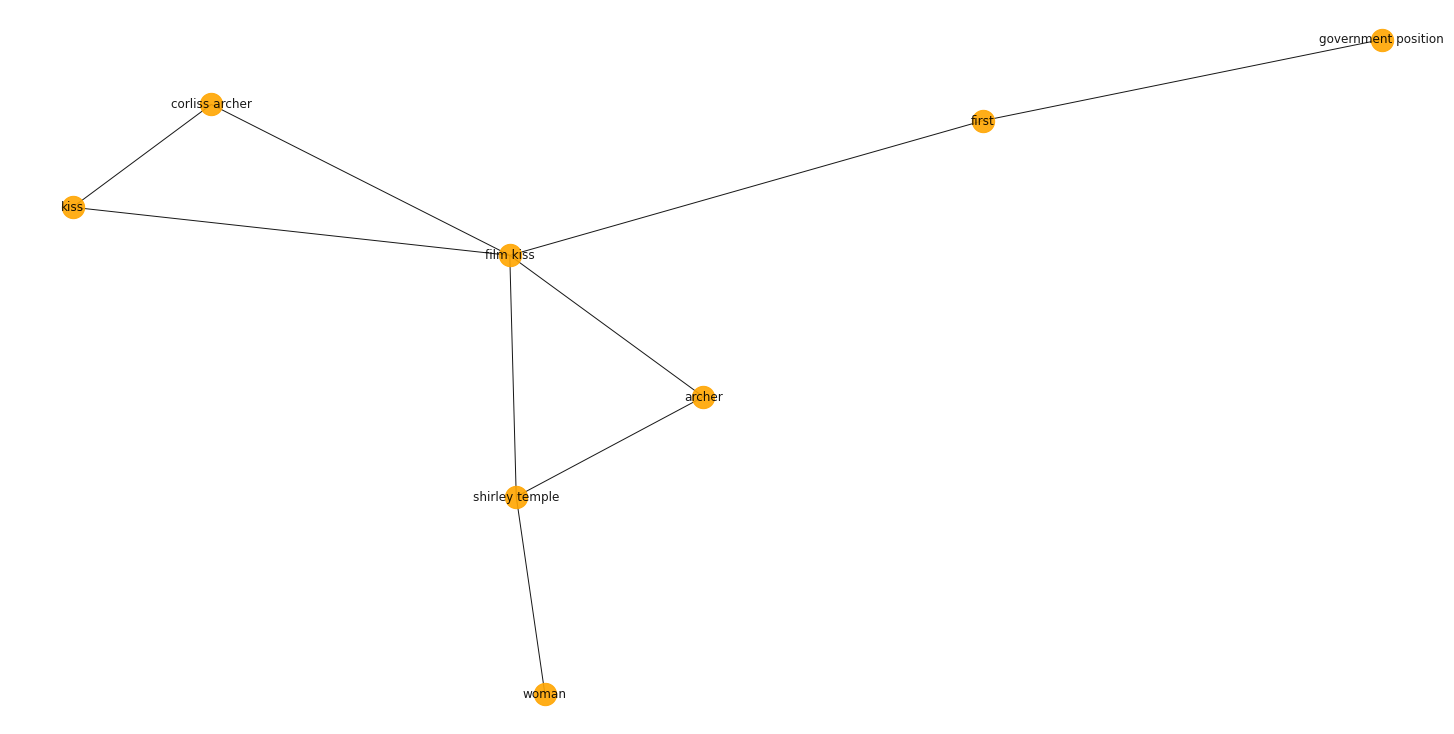

In [27]:
if __name__ == "__main__":
    main()

In [28]:
### Run all examples from the json file

# with open("/xdisk/msurdeanu/fanluo/hotpotQA/Data/hotpot_dev_distractor_v1.json", "r", encoding='utf-8') as f:  
#     json_dict = json.load(f)
#     for e_id, example in enumerate(json_dict):
#         print("e_id: ", e_id, "_id: ", example["_id"])
#         reduce_context_with_phares_graph(example, example["_id"])  

### Sandbox

In [29]:
title = "chris jones footballer born 1985"
sents =  ['chris is welsh semiprofessional footballer currently playing for cymru alliance side porthmadog', 'former professional with leeds united jones is currently in his fourth season with city', 'he made several appearances for leeds and was heavily involved with first team', 'chris was playing with likes of aaron lennon james milner rio ferdinand scott carson and alan smith during his spell with yorkshire outfit']

In [15]:
context = title  + ' ' + TITLE_END + ' ' + (' ' + SENT_MARKER_END +' ').join(sents)

In [16]:
context_doc = nlp1(context)
title, sents = context_doc._.coref_resolved.split(TITLE_END)  
sents = sents.split(SENT_MARKER_END)
sent_docs = list(nlp2.pipe([title] + sents))     

In [17]:
context_doc._.coref_resolved

'chris born 1985 , </t> .  chris is welsh semiprofessional footballer currently playing for cymru alliance side porthmadog , </sent> ,  former professional with leeds united jones is currently in welsh semiprofessional footballer currently playing for cymru alliance side porthmadog , </sent> ,  former professional with leeds united jones fourth season with city , </sent> ,  welsh semiprofessional footballer currently playing for cymru alliance side porthmadog , </sent> ,  former professional with leeds united jones made several appearances for leeds united jones and was heavily involved with first team , </sent> ,  chris was playing with likes of aaron lennon james milner rio ferdinand scott carson and alan smith during welsh semiprofessional footballer currently playing for cymru alliance side porthmadog , </sent> ,  former professional with leeds united jones spell with yorkshire outfit'

In [18]:
context = "brown state fishing lake , </t> .  brown state fishing lake sometimes also known as brown state fishing lake and wildlife area is protected area in brown county kansas in united states , </sent> ,  lake is 62 acres 025 km² in area and up to 13 feet 4 m deep , </sent> ,  area was formerly known as brown county state park and is 8 miles 13 km east of hiawatha kansas"
 

In [19]:
context_doc = nlp1(context)
print(context_doc._.coref_resolved)
print(context_doc._.coref_clusters)
print(context_doc._.coref_clusters[1].mentions)
print(context_doc._.coref_clusters[1].mentions[-1])
print(context_doc._.coref_clusters[1].mentions[-1]._.coref_cluster.main)

brown state fishing lake , </t> .  brown state fishing lake sometimes also known as brown state fishing lake and wildlife area is protected area in brown county kansas in united states , brown state fishing lake is 62 acres 025 km² in area and up brown state fishing lake and wildlife area was formerly known as brown county state park and is 8 miles 13 km east of hiawatha kansas
[brown: [brown, brown], brown state fishing lake: [brown state fishing lake, brown state fishing lake, </sent> ,  lake], brown state fishing lake and wildlife area: [brown state fishing lake and wildlife area, to 13 feet 4 m deep , </sent> ,  area], brown county: [brown county, brown county], kansas: [kansas, kansas]]
[brown state fishing lake, brown state fishing lake, </sent> ,  lake]
</sent> ,  lake
brown state fishing lake


In [20]:
context = "fishing lake , </t> .  fishing lake is lake in canadian province of saskatchewan , </sent> ,  lake is located between highway 5 and highway 16 22 km north of town of foam lake saskatchewan and 24 km east of town of wadena saskatchewan , </sent> ,  lake does not have effective outlet channel and so is prone to flooding , </sent> ,  record floods in 2007 resulted in plan by government of saskatchewan to lower level of lake by digging drainage channel , </sent> ,  fishing lake first nation opposed this plan and instead flood control berms were constructed"
context_resolved = nlp1(context)._.coref_resolved

print(context_resolved)
title_coref_resolved, sents_coref_resolved = context_resolved.split(TITLE_END)  
sents_coref_resolved = sents_coref_resolved.split(SENT_MARKER_END) 
sent_docs = list(nlp2.pipe([title_coref_resolved] + sents_coref_resolved))     
para_phrases = []                                        
for sent_doc in sent_docs:                                    # each sent in a para
    sent_phrases = [(p.text, p.rank) for p in sent_doc._.phrases if(p.text != '')]  # phrases from each sentence 
    para_phrases.append(sent_phrases)     
print(para_phrases)
print("\n")  

fishing lake , </t> .  fishing lake is lake in canadian province of saskatchewan , </sent> ,  lake is located between highway 5 and highway 16 22 km north of town of foam lake saskatchewan and 24 km east of town of wadena saskatchewan , </sent> ,  lake does not have effective outlet channel and so is prone to flooding , </sent> ,  record floods in 2007 resulted in plan by government of saskatchewan to lower level of fishing lake by digging drainage channel , </sent> ,  lake saskatchewan opposed this plan and instead flood control berms were constructed
[[('fishing lake', 0.4330127018922193), ('lake', 0.3333333333333333)], [('canadian province', 0.2616585242462876), ('lake', 0.23150520948869216), ('province', 0.20142482587913918), ('canadian', 0.20142482587913918), ('saskatchewan', 0.16895618538601082), ('fishing lake', 0.13160696215647302)], [('16 22 km', 0.2026452065409755), ('24 km', 0.18671728907198992), ('foam lake saskatchewan', 0.1852953057904101), ('lake saskatchewan', 0.1764118

In [21]:
from spacy.tokens import Span
text = 'valhalla highlands historic district also known as lake valhalla is national historic district located near cold spring in putnam county new york'
doc = nlp2(text)
for chunk in doc.noun_chunks:
    print('chunk: ', chunk.text) 
    print('root: ',  chunk.root.text)
#     span = Span(doc, chunk.root.i, chunk.root.i+1)
#     print(span)
#     print(span.start)

chunk:  valhalla highlands historic district
root:  district
chunk:  lake valhalla
root:  valhalla
chunk:  national historic district
root:  district
chunk:  cold spring
root:  spring
chunk:  putnam county new york
root:  york


In [22]:
context = "this list provides guide to opera composers as determined by their presence on majority of compiled lists of significant opera composers , </sent> ,  see lists consulted section for full details , </sent> ,  composers run from jacopo peri who wrote first ever opera in late 16th century italy to john adams one of leading figures in contemporary operatic world , </sent> ,  brief accompanying notes offer explanation as to why each composer has been considered major , </sent> ,  also included is section about major women opera composers compiled from same lists , </sent> ,  for introduction to operatic history see opera , </sent> ,  organisation of list is by birthdate"
context_resolved = nlp1(context)._.coref_resolved

print(context_resolved)
sents_coref_resolved = context_resolved.split(SENT_MARKER_END)  

this list provides guide to opera composers as determined by opera composers presence on majority of compiled lists of significant opera composers , </sent> ,  see lists consulted section for full details , </sent> ,  composers run from jacopo peri who wrote first ever opera in late 16th century italy to john adams one of leading figures in contemporary operatic world , </sent> ,  brief accompanying notes offer explanation as to why each composer has been considered major , </sent> ,  also included is section about major women opera composers compiled from same lists , </sent> ,  for introduction to operatic history see opera , </sent> ,  organisation of list is by birthdate
